MSE: 6.969963715342071e-29 R2: 1.0
{'johnny.palmer@enron.com', 'rhonda.denton@enron.com', 'bobette.riner@ipgdirect.com', 'patti.thompson@enron.com', 'sally.beck@enron.com', 'lydia.delgado@enron.com', 'john.arnold@enron.com'}


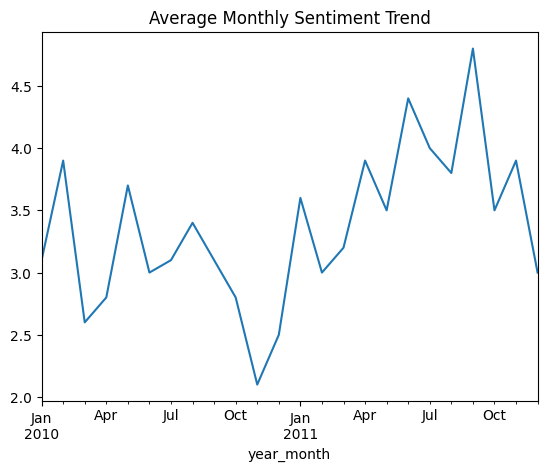

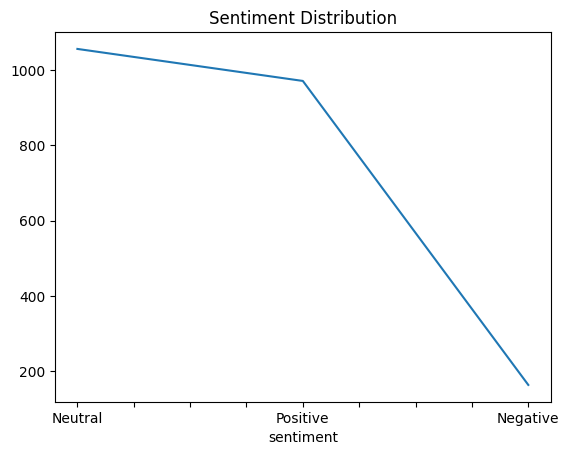

In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def label_sentiment(text):
    p = TextBlob(str(text)).sentiment.polarity
    if p > 0.1: return "Positive"
    if p < -0.1: return "Negative"
    return "Neutral"

def run_pipeline(path):
    df = pd.read_csv(path, parse_dates=['date'])
    df.columns = [c.strip().lower() for c in df.columns]
    df = df.rename(columns={'body':'message','from':'employee_id'})

    df['sentiment'] = df['message'].apply(label_sentiment)
    df['polarity'] = df['message'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['message_length'] = df['message'].astype(str).str.len()
    df['word_count'] = df['message'].astype(str).str.split().map(len)
    df['score'] = df['sentiment'].map({'Positive':1,'Negative':-1,'Neutral':0})

    df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    monthly = df.groupby(['employee_id','year_month'])['score'].sum().reset_index()

    # rankings
    rankings={}
    for m in monthly['year_month'].unique():
        mdf=monthly[monthly['year_month']==m]
        rankings[m]=(
            mdf.sort_values(['score','employee_id'],ascending=[False,True]).head(3),
            mdf.sort_values(['score','employee_id'],ascending=[True,True]).head(3)
        )

    # flight risk
    flight_risk=set()
    for emp,g in df.sort_values('date').groupby('employee_id'):
        neg=g[g['sentiment']=="Negative"]['date'].reset_index(drop=True)
        i=j=0
        while i < len(neg):
            while j < len(neg) and (neg[j]-neg[i]).days<=30: j+=1
            if j-i>=4: flight_risk.add(emp); break
            i+=1

    # features
    features=df.groupby(['employee_id','year_month']).agg(
        message_count=('message','count'),
        avg_length=('message_length','mean'),
        negative_count=('sentiment',lambda s:(s=="Negative").sum()),
        positive_count=('sentiment',lambda s:(s=="Positive").sum()),
        neutral_count=('sentiment',lambda s:(s=="Neutral").sum())
    ).reset_index().merge(monthly,on=['employee_id','year_month'],how='left').fillna(0)

    # train model
    X=features[['message_count','avg_length','negative_count','positive_count','neutral_count']]
    y=features['score']
    if len(df)>2:
        Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.25,random_state=42)
        model=LinearRegression().fit(Xtr,ytr)
        yp=model.predict(Xte)
        mse=mean_squared_error(yte,yp); r2=r2_score(yte,yp)
        print("MSE:",mse,"R2:",r2)
    else:
        print("Not enough data to train model.")

    # graphs
    plt.figure()
    monthly.groupby('year_month')['score'].mean().plot()
    plt.title("Average Monthly Sentiment Trend")
    plt.savefig("sentiment_trend.png")


    plt.figure()
    df['sentiment'].value_counts().plot()
    plt.title("Sentiment Distribution")
    plt.savefig("sentiment_dist.png")


    df.to_csv("/content/drive/MyDrive/Employee_sentiment_analysis/updated_employee_sentiment.csv",index=False)
    monthly.rename(columns={'year_month': 'month'}, inplace=True)

    # Save monthly scores CSV
    monthly.to_csv("/content/drive/MyDrive/Employee_sentiment_analysis/monthly_scores_each_employee.csv", index=False)

    return flight_risk

if __name__ == '__main__':
  path="/content/drive/MyDrive/Employee_sentiment_analysis/employee_sentiment_project_test.csv"
  exec=run_pipeline(path)
  print(exec)